In [175]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import json
import matplotlib
import scipy
import os

matplotlib.rcParams['figure.figsize'] = [12, 5]

In [176]:
with open("../export/image_catalogue.json") as ic_file:
    image_catalog = json.load(ic_file)
    types_map = [v["type"] for k, v in sorted(image_catalog.items()) if k.isnumeric()]
    file_names_map = [os.path.basename(v["filepath"]) for k, v in sorted(image_catalog.items()) if k.isnumeric()]

In [177]:
rating_files = glob.glob("../export/*_rating.csv")
rating_files.sort()
rating_files[-1]

'../export/20230105-163156_rating.csv'

In [178]:
questions = ["Fictional/Real", "Human-made/Human-like", "Eerie/Ordinary", "Unsettling/Plain", "Creepy/Dull",
             "Hair-raising/Unemotional", "Hostile/Friendly", "Grumpy/Cheerful", "Cold-hearted/Warm-hearted"]

In [179]:
ratings = pd.read_csv(rating_files[-1], index_col=["index"],
                      names=["index", "timestamp", "img"] + questions + ["uid"])
ratings = ratings.reset_index().drop(["index"], axis=1)
ratings["type"] = [types_map[img - 1] for img in ratings["img"]]
ratings["filename"] = [file_names_map[img - 1] for img in ratings["img"]]

ratings["Fictional/Real"] -= 4
ratings["Human-made/Human-like"] -= 4
ratings["Eerie/Ordinary"] = 7 - ratings["Eerie/Ordinary"]
ratings["Unsettling/Plain"] = 7 - ratings["Unsettling/Plain"]
ratings["Creepy/Dull"] = 7 - ratings["Creepy/Dull"]
ratings["Hair-raising/Unemotional"] = 7 - ratings["Hair-raising/Unemotional"]
ratings["Hostile/Friendly"] -= 4
ratings["Grumpy/Cheerful"] -= 4
ratings["Cold-hearted/Warm-hearted"] -= 4

# Image Distribution

<AxesSubplot: >

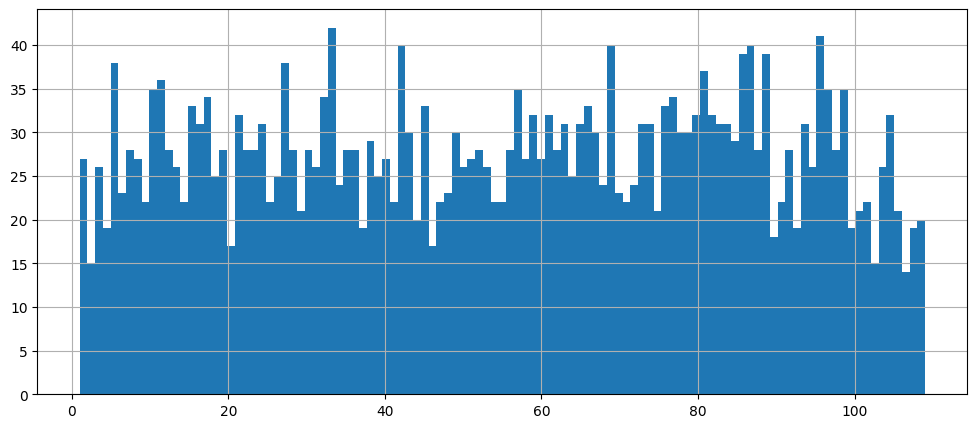

In [180]:
ratings["img"].hist(bins=max(ratings["img"]))

# Ratings Distribution

In [181]:
def analyse_columns(column, ratings):
    fig, axes = plt.subplots(1, 4)
    fig.suptitle(column, fontsize=16)
    ratings[column].hist(bins=max(ratings[column]), ax=axes[0])
    axes[0].set_title('all')
    ratings[ratings["type"] == "human"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]), ax=axes[1])
    axes[1].set_title('human')
    ratings[ratings["type"] == "semi-realistic"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]),
                                                              ax=axes[2])
    axes[2].set_title('semi-realistic')
    ratings[ratings["type"] == "animated_grey"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]),
                                                             ax=axes[3])
    axes[3].set_title('animated_grey')
    plt.show()
    f, f_p = scipy.stats.f_oneway(ratings[ratings["type"] == "human"][column],
                                  ratings[ratings["type"] == "semi-realistic"][column],
                                  ratings[ratings["type"] == "animated_grey"][column])
    u, u_p = scipy.stats.mannwhitneyu(ratings[ratings["type"] == "semi-realistic"][column],
                                      ratings[column])

    print(
        "All: {:.2f}, Human: {:.2f}, Semi Realistic: {:.2f}, Cartoon: {:.2f}, Anova p-value: {:.2f}, Mann–Whitney p-value: {:.2f} (semi vs all)".format(
            ratings[column].mean(),
            ratings[ratings["type"] == "human"][column].mean(),
            ratings[ratings["type"] == "semi-realistic"][column].mean(),
            ratings[ratings["type"] == "animated_grey"][column].mean(), f_p, u_p))

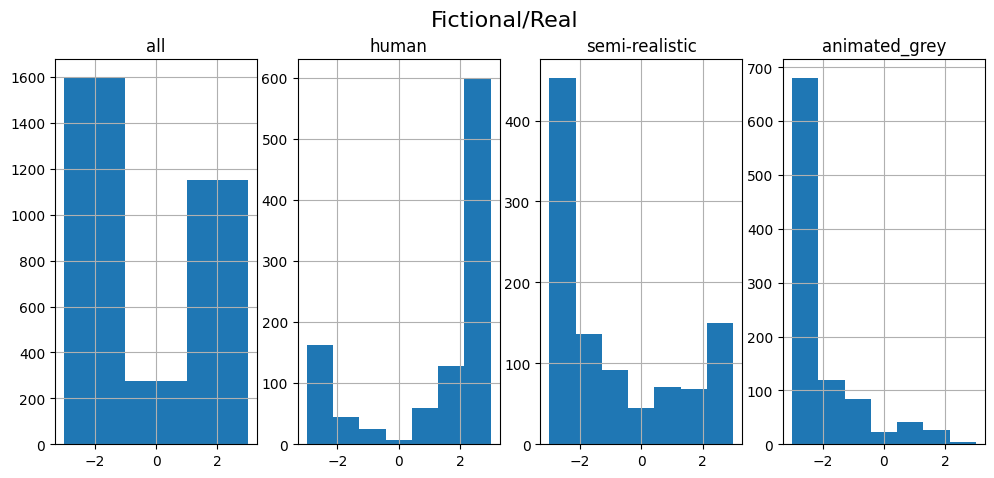

All: -0.60, Human: 1.48, Semi Realistic: -1.05, Cartoon: -2.31, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


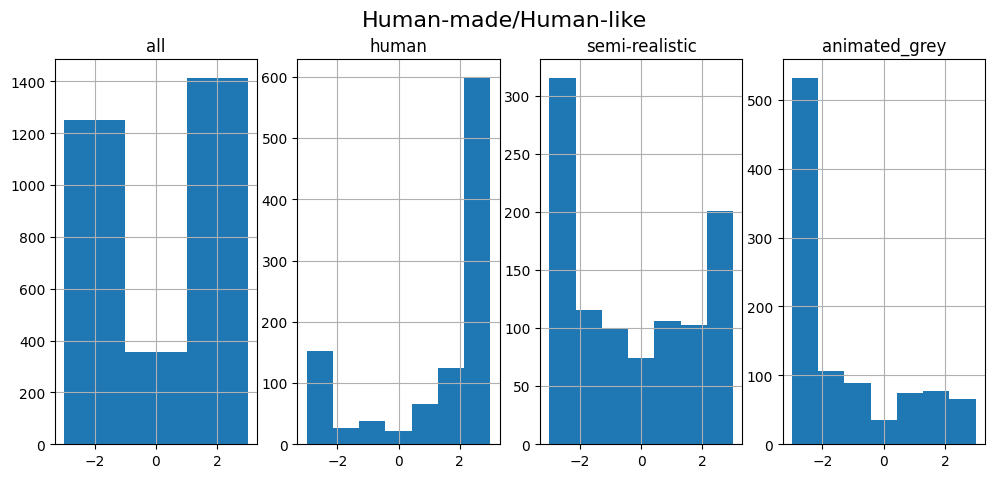

All: -0.09, Human: 1.52, Semi Realistic: -0.36, Cartoon: -1.51, Anova p-value: 0.00, Mann–Whitney p-value: 0.01 (semi vs all)


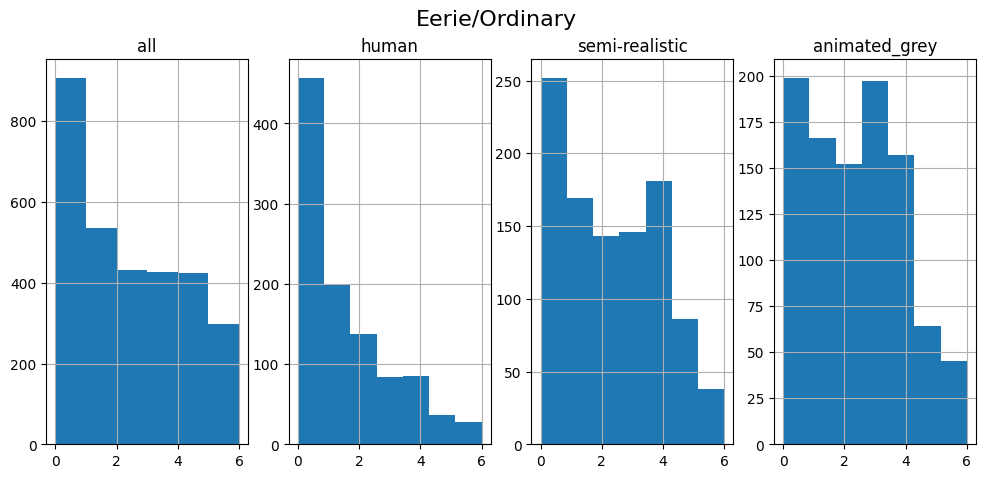

All: 1.98, Human: 1.38, Semi Realistic: 2.24, Cartoon: 2.33, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


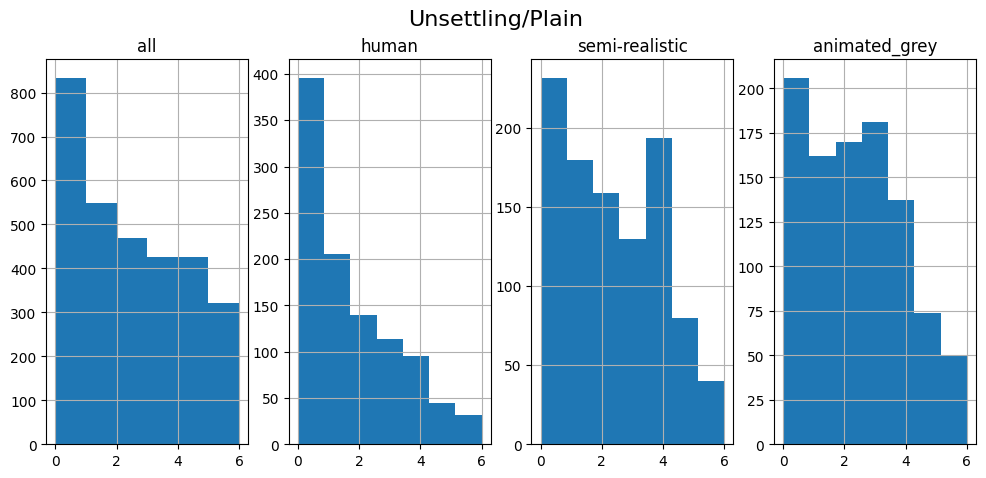

All: 2.05, Human: 1.58, Semi Realistic: 2.27, Cartoon: 2.31, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


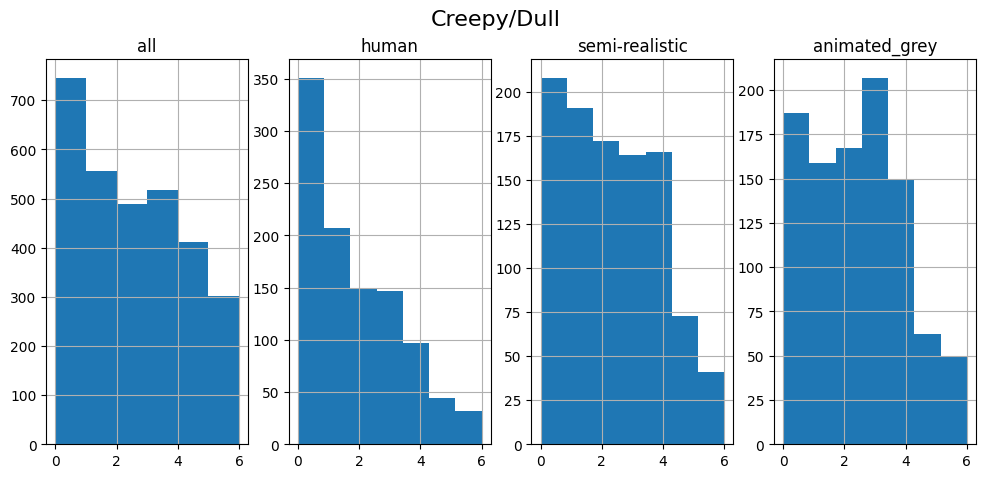

All: 2.11, Human: 1.70, Semi Realistic: 2.27, Cartoon: 2.36, Anova p-value: 0.00, Mann–Whitney p-value: 0.01 (semi vs all)


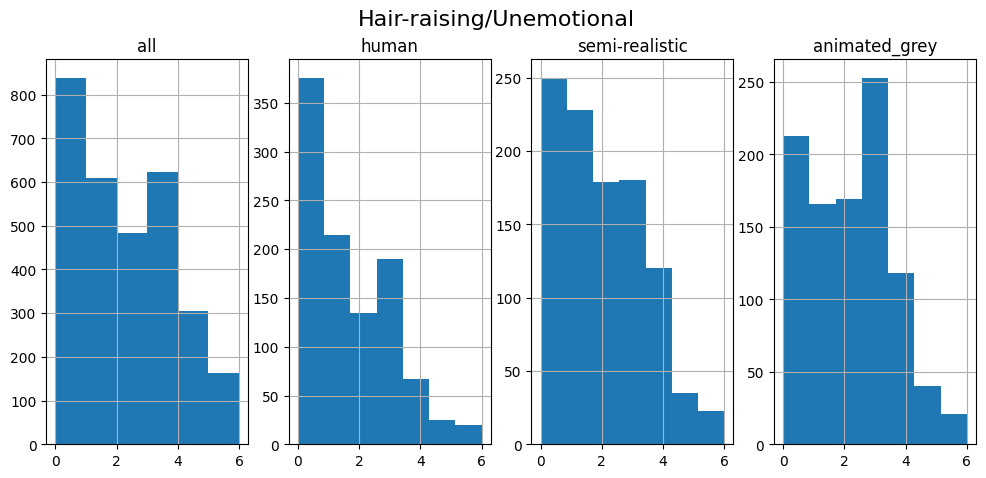

All: 1.84, Human: 1.53, Semi Realistic: 1.89, Cartoon: 2.10, Anova p-value: 0.00, Mann–Whitney p-value: 0.30 (semi vs all)


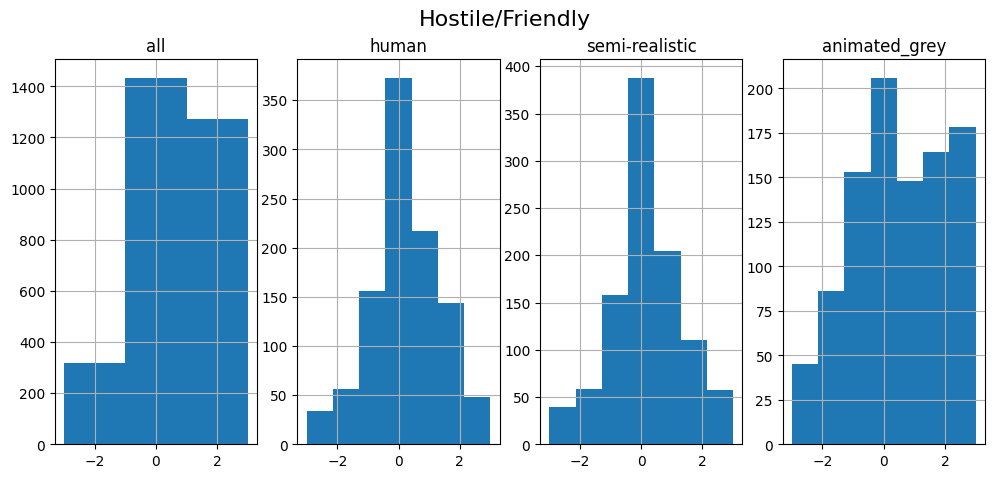

All: 0.34, Human: 0.27, Semi Realistic: 0.20, Cartoon: 0.56, Anova p-value: 0.00, Mann–Whitney p-value: 0.01 (semi vs all)


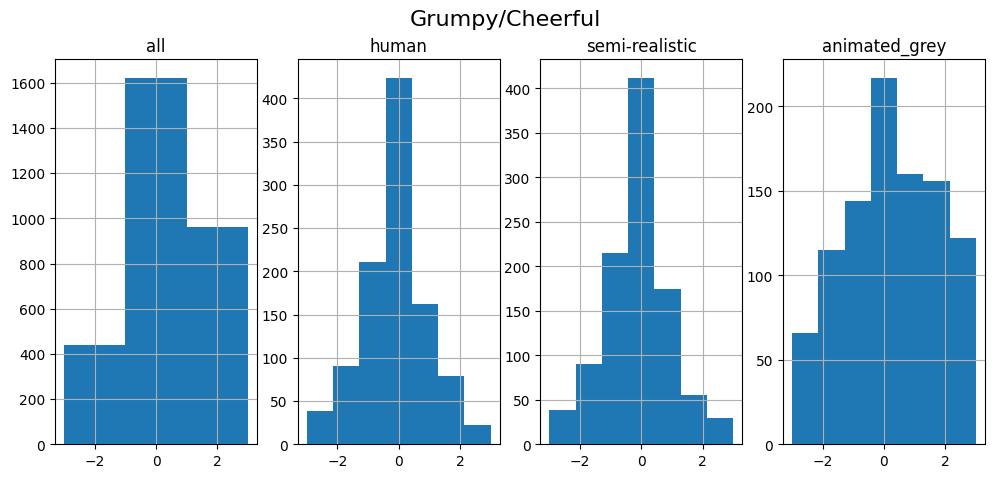

All: 0.00, Human: -0.12, Semi Realistic: -0.13, Cartoon: 0.27, Anova p-value: 0.00, Mann–Whitney p-value: 0.01 (semi vs all)


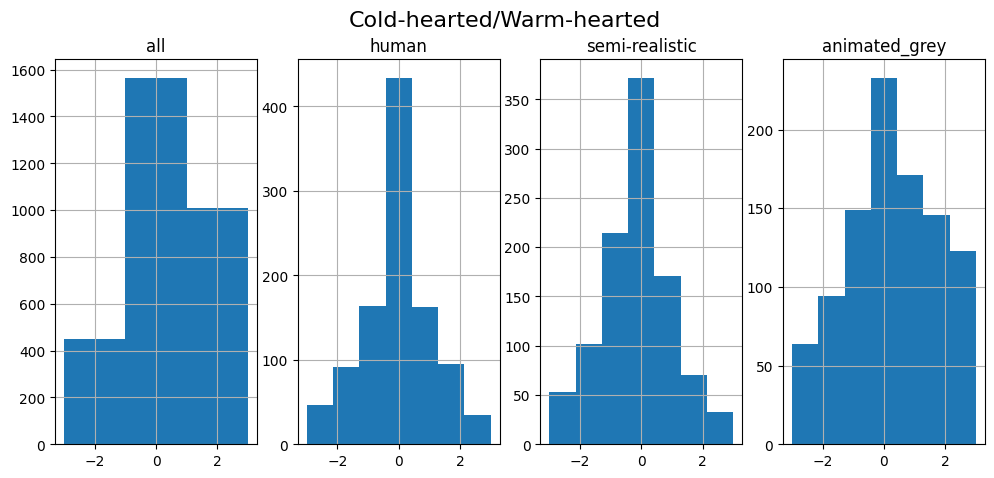

All: 0.04, Human: -0.03, Semi Realistic: -0.16, Cartoon: 0.31, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


In [182]:
for column in questions:
    analyse_columns(column, ratings)

# Exploratory Factor Analysis

In [183]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

items = ratings[questions]
chi_square_value, p_value = calculate_bartlett_sphericity(items)
print("Bartlett ’s test:")
print(chi_square_value, p_value)
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(items)
print("KMO:")
print(kmo_model)
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=3, rotation="varimax")
fa.fit(items)
print("Loadings:")
print(fa.loadings_)

Bartlett ’s test:
20711.60541499606 0.0
KMO:
0.8135226977912151
Loadings:
[[-0.20357605 -0.08039614  0.89415945]
 [-0.14351102 -0.05494885  0.84339195]
 [ 0.81456878 -0.1967002  -0.23590449]
 [ 0.88557155 -0.2314381  -0.14652032]
 [ 0.88225188 -0.23963732 -0.10215655]
 [ 0.74278027 -0.17426688 -0.10464759]
 [-0.3111885   0.84895531 -0.05212418]
 [-0.13880549  0.83759124 -0.05810381]
 [-0.2362062   0.85813724 -0.04953671]]


# Factors distributions

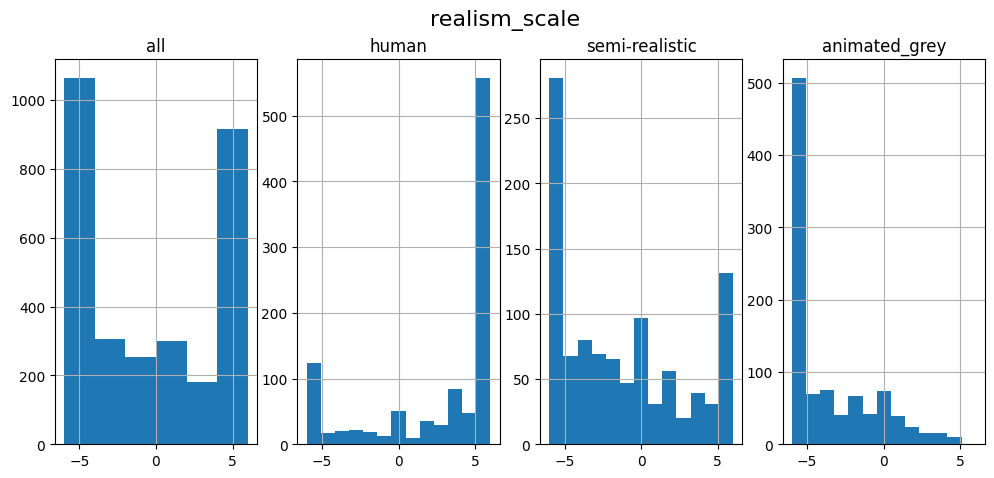

All: -0.69, Human: 2.99, Semi Realistic: -1.41, Cartoon: -3.81, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


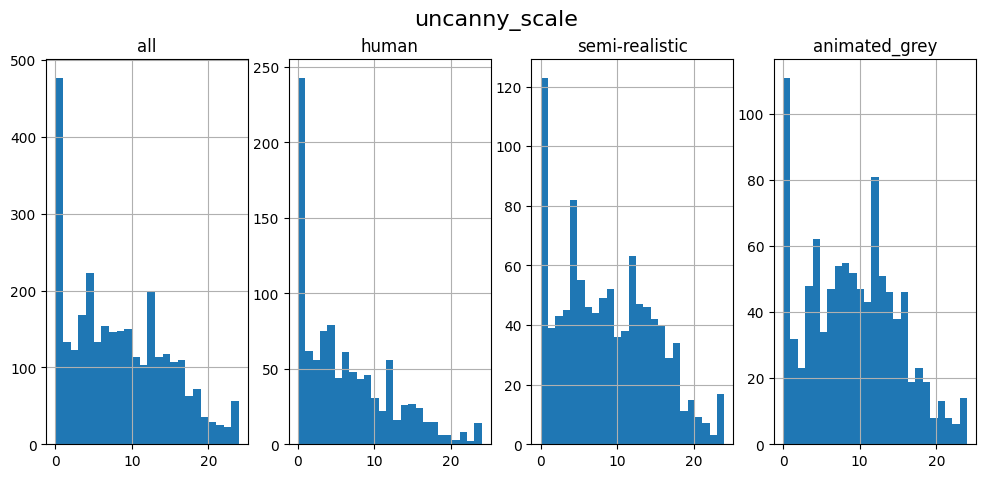

All: 7.96, Human: 6.19, Semi Realistic: 8.67, Cartoon: 9.10, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


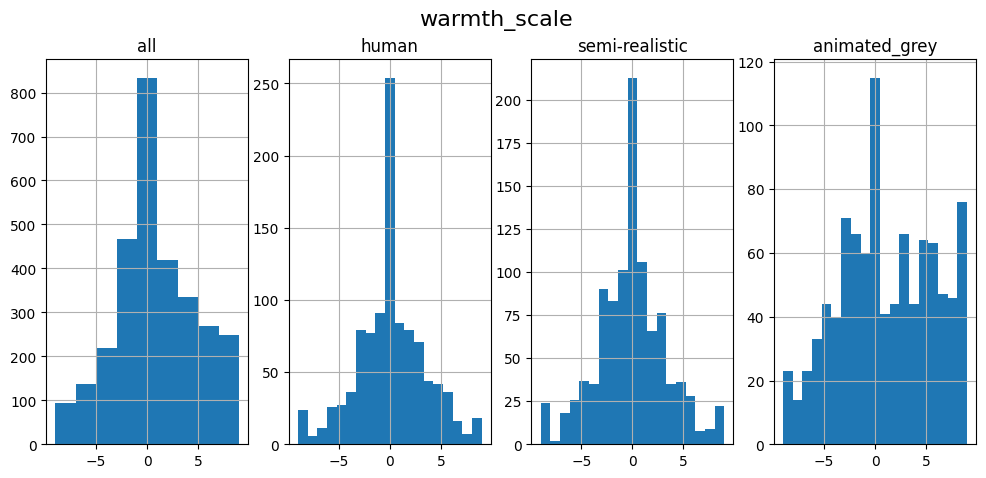

All: 0.38, Human: 0.13, Semi Realistic: -0.09, Cartoon: 1.14, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


In [184]:
ratings["realism_scale"] = ratings["Fictional/Real"] + ratings["Human-made/Human-like"]
ratings["uncanny_scale"] = ratings["Eerie/Ordinary"] + ratings["Unsettling/Plain"] + ratings[
    "Creepy/Dull"] + ratings["Hair-raising/Unemotional"]
ratings["warmth_scale"] = ratings["Hostile/Friendly"] + ratings["Grumpy/Cheerful"] + ratings[
    "Cold-hearted/Warm-hearted"]

for column in ["realism_scale", "uncanny_scale", "warmth_scale"]:
    analyse_columns(column, ratings)

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_4690/4286937560.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()


Text(0, 0.5, 'uncanny_scale')

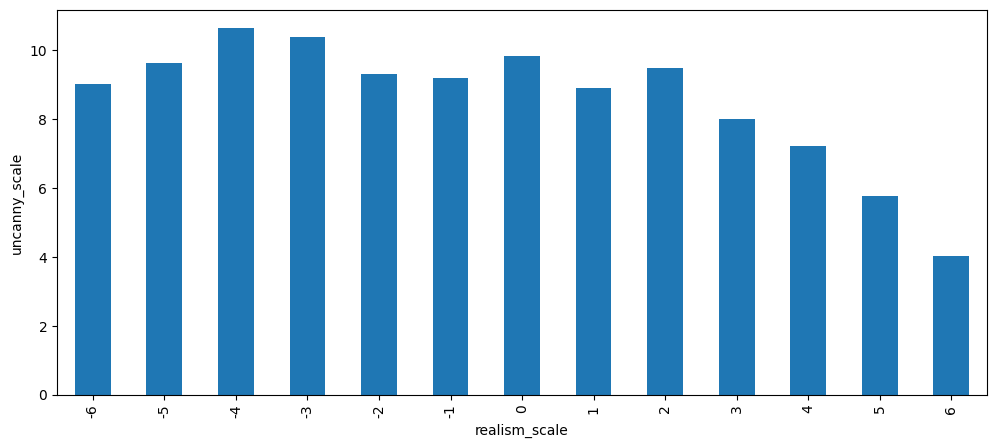

In [185]:
ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()
plt.ylabel("uncanny_scale")

# Best Images for the EEG Experiment

In [186]:
cohort_size = 20
best_images = pd.concat([
ratings[ratings["type"] == "human"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:cohort_size],
ratings[ratings["type"] == "semi-realistic"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=False).reset_index()["img"][:cohort_size],
ratings[ratings["type"] == "animated_grey"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:cohort_size]
    ]).to_list()
top_ratings = ratings[ratings["img"].isin(best_images)]

top_ratings.groupby(["filename","type","img"]).mean().to_csv("../export/best_dataset.csv")

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_4690/1295122275.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings[ratings["type"] == "human"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:cohort_size],
/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_4690/1295122275.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings[ratings["type"] == "semi-realistic"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=False).reset_index()["img"][:cohort_size],
/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_4690/12

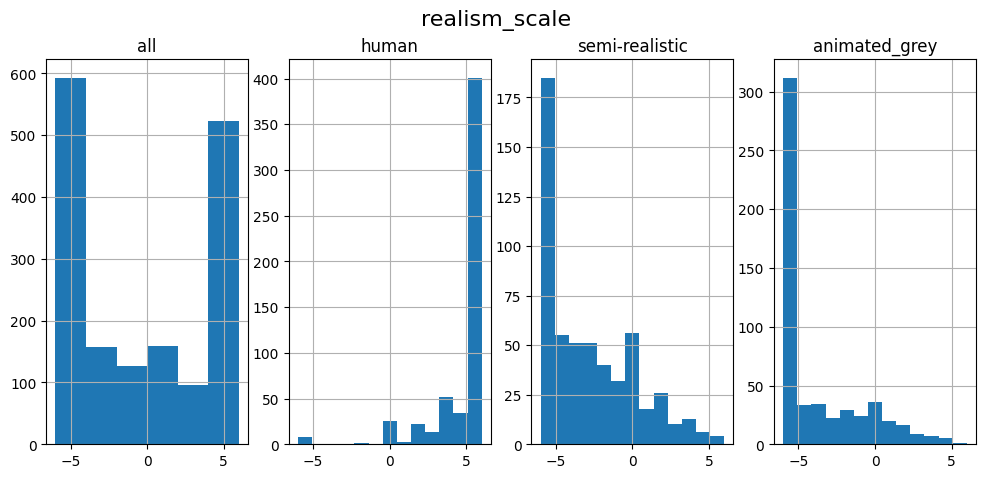

All: -0.61, Human: 5.04, Semi Realistic: -3.01, Cartoon: -3.98, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


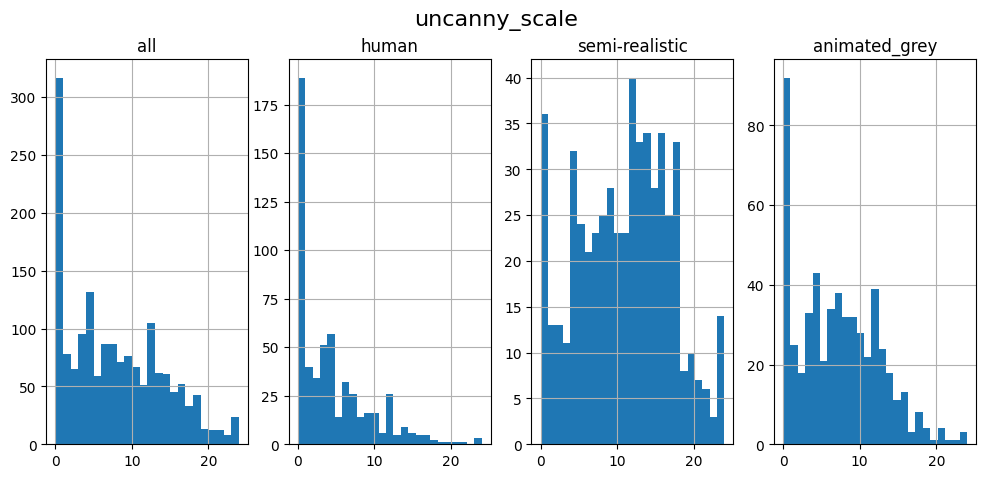

All: 7.36, Human: 4.22, Semi Realistic: 10.87, Cartoon: 7.06, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


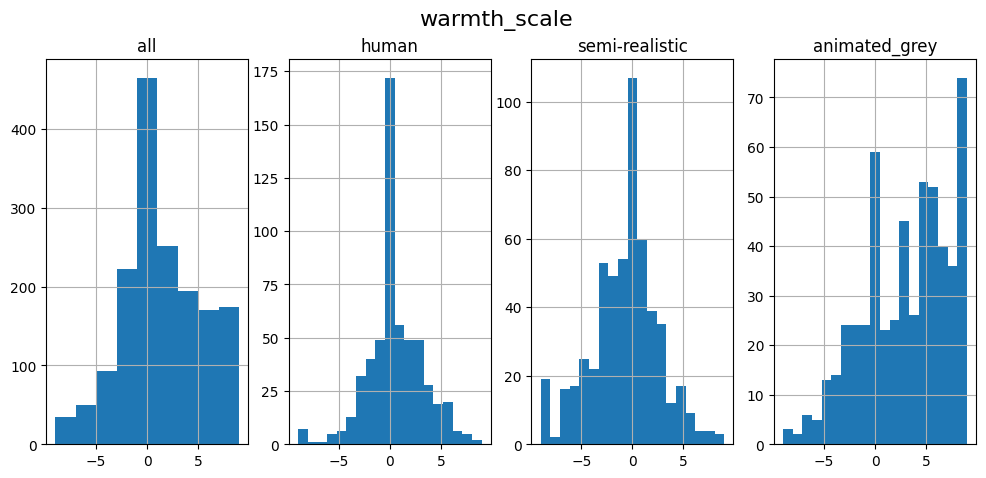

All: 1.00, Human: 0.56, Semi Realistic: -0.75, Cartoon: 3.18, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs all)


In [187]:
for column in ["realism_scale", "uncanny_scale", "warmth_scale"]:
    analyse_columns(column, top_ratings)

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_4690/3368236120.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()


Text(0, 0.5, 'uncanny_scale')

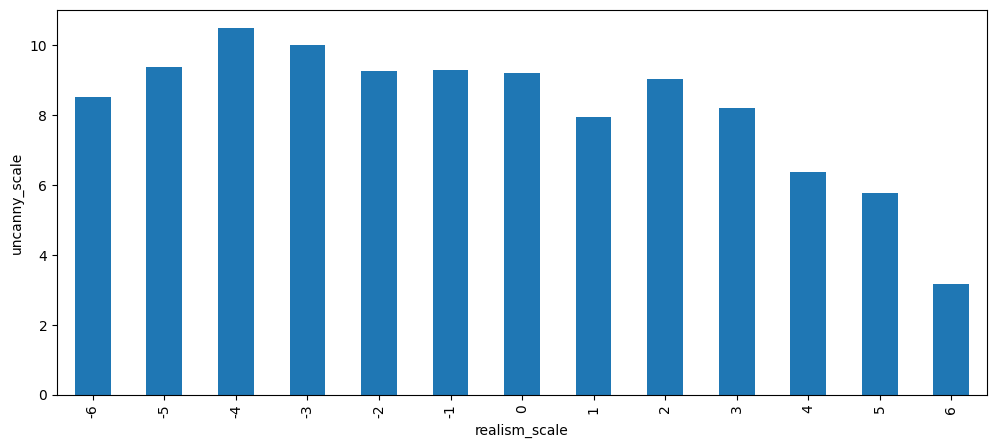

In [188]:
top_ratings.groupby("realism_scale").mean()["uncanny_scale"].plot.bar()
plt.ylabel("uncanny_scale")